In [14]:
import random
import gym
import numpy as np
import torch
import torch.nn.functional as F
import collections
import matplotlib.pyplot as plt
from tqdm import tqdm


class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

Common functions definition

In [15]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) 

    def add(self, state, action, reward, next_state, done): 
        self.buffer.append((state, action, reward, next_state, done)) 

    def sample(self, batch_size): 
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done 

    def size(self): 
        return len(self.buffer)

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)
                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)
                    state = next_state
                    episode_return += reward
                return_list.append(episode_return)
                agent.update(transition_dict)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list

def train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list


def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

DQN, Double DQN Implementation

In [21]:
class VAnet(torch.nn.Module):
    ''' 只有一层隐藏层的A网络和V网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享网络部分
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1)  # Q值由V值和A值计算得到
        return Q

In [22]:
class DQN:
    ''' DQN算法,包括Double DQN '''
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        if dqn_type == 'DuelingDQN':  # Dueling DQN采取不一样的网络框架
            self.q_net = VAnet(state_dim, hidden_dim,
                               self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim,
                                      self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim,
                              self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim,
                                     self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action
    
    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        if self.dqn_type == 'DoubleDQN': # DQN与Double DQN的区别
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else: # DQN的情况
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [17]:
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11  # 将连续动作分成11个离散动作


def dis_to_con(discrete_action, env, action_dim):  # 离散动作转回连续的函数
    action_lowbound = env.action_space.low[0]  # 连续动作的最小值
    action_upbound = env.action_space.high[0]  # 连续动作的最大值
    return action_lowbound + (discrete_action /
                              (action_dim - 1)) * (action_upbound -
                                                   action_lowbound)

In [18]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,
              batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995  # 平滑处理
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    action_continuous = dis_to_con(action, env,
                                                   agent.action_dim)
                    next_state, reward, done, _ = env.step([action_continuous])
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list

Iteration 9: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s, episode=200, return=-210.971]


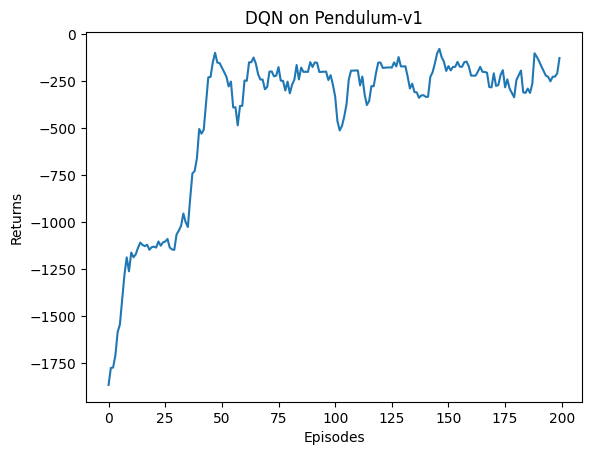

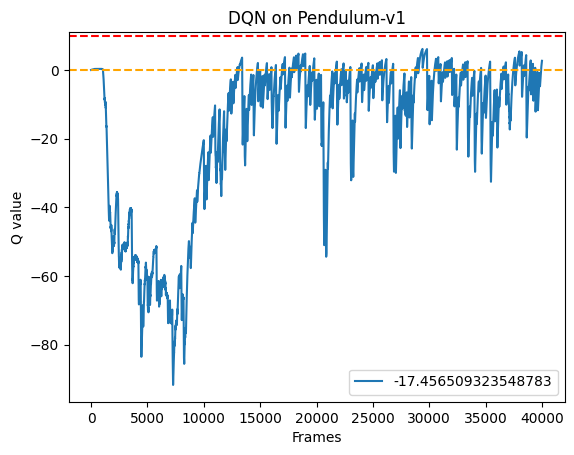

In [19]:
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list, label=str(sum(max_q_value_list) / len(max_q_value_list)))
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.legend()
plt.show()

Iteration 9: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s, episode=200, return=-260.407]


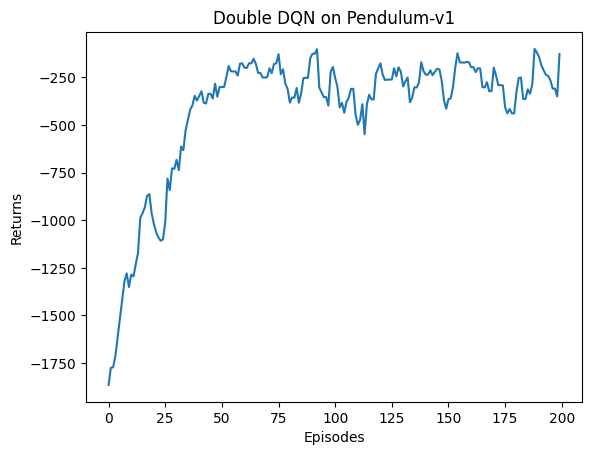

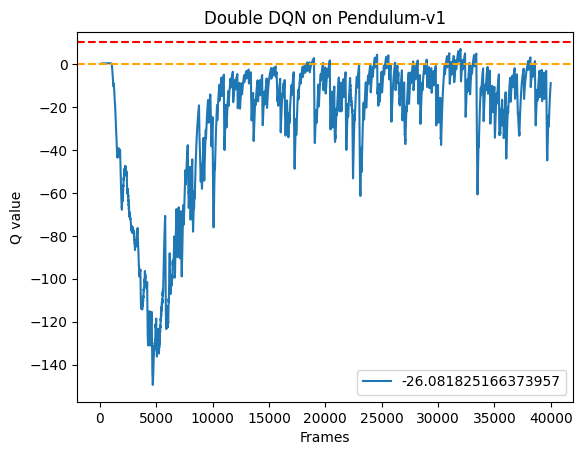

In [20]:
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DoubleDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list, label=str(sum(max_q_value_list) / len(max_q_value_list)))
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Double DQN on {}'.format(env_name))
plt.legend()
plt.show()

Iteration 9: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s, episode=200, return=-254.835]


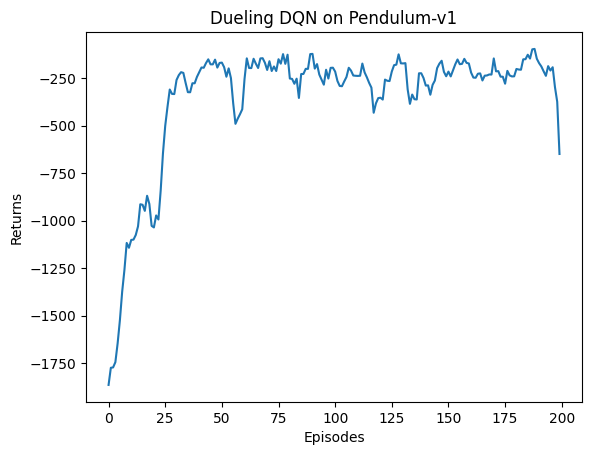

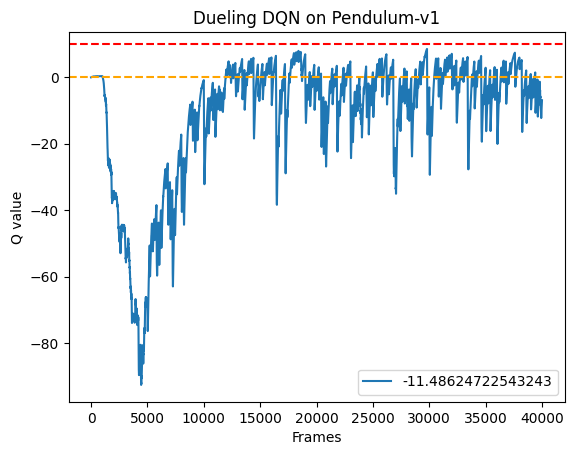

In [23]:
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DuelingDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list, label=str(sum(max_q_value_list) / len(max_q_value_list)))
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Dueling DQN on {}'.format(env_name))
plt.legend()
plt.show()

在传统的 DQN 基础上，有两种非常容易实现的变式——Double DQN 和 Dueling DQN，Double DQN 解决了 DQN 中对值的过高估计，而 Dueling DQN 能够很好地学习到不同动作的差异性，在动作空间较大的环境下非常有效。从 Double DQN 和 Dueling DQN 的方法原理中，我们也能感受到深度强化学习的研究是在关注深度学习和强化学习有效结合：一是在深度学习的模块的基础上，强化学习方法如何更加有效地工作，并避免深度模型学习行为带来的一些问题，例如使用 Double DQN 解决值过高估计的问题；二是在强化学习的场景下，深度学习模型如何有效学习到有用的模式，例如设计 Dueling DQN 网络架构来高效地学习状态价值函数以及动作优势函数。